In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from networks import AutoEncoder
from dataset import NumpyCsvDataSet

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [3]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [4]:
data_folder = 'data/img_auto_encoder/version2'
train_data = NumpyCsvDataSet(data_folder + '/train.csv')
test_data = NumpyCsvDataSet(data_folder + '/test.csv')
training_loader = DataLoader(train_data, batch_size=50, shuffle=True)
test_loader = DataLoader(test_data, batch_size=3, shuffle=True)
print (train_data.data.shape)

torch.Size([10000, 1026])


In [5]:
x_dim = 2
img_res = 32
img_size = img_res * img_res

In [161]:
%reset -f AutoEncoder
%reset -f net
from networks import AutoEncoder

Don't know how to reset  autoencoder, please run `%reset?` for details
Don't know how to reset  net, please run `%reset?` for details


In [162]:
net = AutoEncoder()
net.train()

AutoEncoder(
  (encoder): Sequential(
    (enc_conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_relu1): ReLU()
    (enc_conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_relu2): ReLU()
    (enc_conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_relu3): ReLU()
    (enc_reshape1): Reshape()
    (enc_fc1): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (dec_fc1): Linear(in_features=2, out_features=128, bias=True)
    (dec_relu4): ReLU()
    (dec_reshape1): Reshape()
    (dec_convt3): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (dec_relu3): ReLU()
    (dec_convt2): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (dec_relu2): ReLU()
    (dec_conv1): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (dec_sigm

In [163]:
expt_prefix = 'Training-AutoEncoder-'
expt_name = expt_prefix + time.strftime('%m-%d-%H-%M-%S')
print (expt_name)

Training-AutoEncoder-01-22-16-47-37


In [164]:
# expt_name = 'Training-AutoEncoder-01-18-16-55-55'
folder = './saved_model/img_auto_encoder/' + expt_name
PATH = folder + '/autoenc.pth'

In [165]:
print ('--------------------------------------------')
print ('        Network Parameter Statistics')
print ('--------------------------------------------')
total = 0
layer = 0
for p in net.parameters():
    if p.requires_grad:
        total += p.numel()
        print ('Params for layer {} = {}'.format(layer+1, p.numel()))
        layer += 1
print ('--------------------------------------------')
print ('Total: {}'.format(total))
print ('--------------------------------------------')
# trainable_params_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
# print ('Total Number of parameters = {}'.format(trainable_params_count))
net

--------------------------------------------
        Network Parameter Statistics
--------------------------------------------
Params for layer 1 = 36
Params for layer 2 = 4
Params for layer 3 = 144
Params for layer 4 = 4
Params for layer 5 = 288
Params for layer 6 = 8
Params for layer 7 = 256
Params for layer 8 = 2
Params for layer 9 = 256
Params for layer 10 = 128
Params for layer 11 = 288
Params for layer 12 = 4
Params for layer 13 = 144
Params for layer 14 = 4
Params for layer 15 = 36
Params for layer 16 = 1
--------------------------------------------
Total: 1603
--------------------------------------------


AutoEncoder(
  (encoder): Sequential(
    (enc_conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_relu1): ReLU()
    (enc_conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_relu2): ReLU()
    (enc_conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_relu3): ReLU()
    (enc_reshape1): Reshape()
    (enc_fc1): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (dec_fc1): Linear(in_features=2, out_features=128, bias=True)
    (dec_relu4): ReLU()
    (dec_reshape1): Reshape()
    (dec_convt3): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (dec_relu3): ReLU()
    (dec_convt2): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (dec_relu2): ReLU()
    (dec_conv1): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (dec_sigm

In [168]:
## Training auto encoder and dynamics network
resume_previous_training = True
epochs = 300
if not resume_previous_training:
    prev_offset = 0

optimizer = optim.Adam(net.parameters(), lr=1e-4)
writer = SummaryWriter('runs/' + expt_name)

running_loss = np.array([0.0, 0.0, 0.0, 0.0])
for epoch in range(epochs):
    for i, data in enumerate(training_loader, 0):
        data = data.float()
        ip_batch = data[:, x_dim:]
        # Divide by 255 to scale the input to bring between 0 and 1
        ip_batch = ip_batch / 255
        op_batch = net(ip_batch)
        total_loss = F.mse_loss(op_batch, ip_batch)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        if i % 100 == 99:
            avg_loss = running_loss / 100
            print ('[%d, %5d] loss: %.3f' % (prev_offset+epoch+1, i+1, avg_loss[0]))
            index = (prev_offset+epoch) * len(training_loader) + i
            writer.add_scalar('training_loss', avg_loss[0], index)
            running_loss[:] = 0.0

prev_offset += epochs

[201,   100] loss: 0.018
[201,   200] loss: 0.018
[202,   100] loss: 0.018
[202,   200] loss: 0.018
[203,   100] loss: 0.018
[203,   200] loss: 0.018
[204,   100] loss: 0.018
[204,   200] loss: 0.018
[205,   100] loss: 0.018
[205,   200] loss: 0.018
[206,   100] loss: 0.018
[206,   200] loss: 0.018
[207,   100] loss: 0.018
[207,   200] loss: 0.018
[208,   100] loss: 0.018
[208,   200] loss: 0.018
[209,   100] loss: 0.018
[209,   200] loss: 0.018
[210,   100] loss: 0.018
[210,   200] loss: 0.018
[211,   100] loss: 0.018
[211,   200] loss: 0.018
[212,   100] loss: 0.018
[212,   200] loss: 0.018
[213,   100] loss: 0.018
[213,   200] loss: 0.018
[214,   100] loss: 0.018
[214,   200] loss: 0.018
[215,   100] loss: 0.018
[215,   200] loss: 0.018
[216,   100] loss: 0.018
[216,   200] loss: 0.018
[217,   100] loss: 0.018
[217,   200] loss: 0.018
[218,   100] loss: 0.018
[218,   200] loss: 0.018
[219,   100] loss: 0.018
[219,   200] loss: 0.018
[220,   100] loss: 0.018
[220,   200] loss: 0.018


[365,   100] loss: 0.017
[365,   200] loss: 0.017
[366,   100] loss: 0.017
[366,   200] loss: 0.017
[367,   100] loss: 0.017
[367,   200] loss: 0.017
[368,   100] loss: 0.017
[368,   200] loss: 0.017
[369,   100] loss: 0.017
[369,   200] loss: 0.017
[370,   100] loss: 0.017
[370,   200] loss: 0.017
[371,   100] loss: 0.017
[371,   200] loss: 0.017
[372,   100] loss: 0.017
[372,   200] loss: 0.018
[373,   100] loss: 0.017
[373,   200] loss: 0.018
[374,   100] loss: 0.017
[374,   200] loss: 0.017
[375,   100] loss: 0.017
[375,   200] loss: 0.017
[376,   100] loss: 0.017
[376,   200] loss: 0.017
[377,   100] loss: 0.017
[377,   200] loss: 0.017
[378,   100] loss: 0.017
[378,   200] loss: 0.017
[379,   100] loss: 0.018
[379,   200] loss: 0.017
[380,   100] loss: 0.017
[380,   200] loss: 0.017
[381,   100] loss: 0.017
[381,   200] loss: 0.017
[382,   100] loss: 0.017
[382,   200] loss: 0.017
[383,   100] loss: 0.017
[383,   200] loss: 0.017
[384,   100] loss: 0.017
[384,   200] loss: 0.017


MSE: 0.011260881088674068


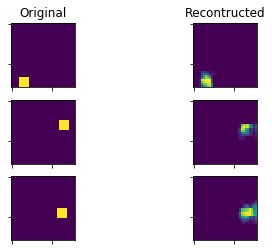

In [169]:
with torch.no_grad():
    test_data = iter(test_loader).next()
#     test_img = np.random.randint(len(test_data))
#     data = torch.as_tensor(test_data[test_img].reshape(1,-1))
    test_data = test_data.float()
    ip = test_data[:, x_dim:] / 255
    op_n = net(ip)
    op = torch.floor(op_n * 255) # Post processing to match the pre-processing of inputs in network
    rows = 3 # test_batch size
    
    print ('MSE: {}'.format(np.mean(np.abs(ip.numpy() - op_n.numpy()) ** 2)))
    
    fig = plt.figure()
    
    for r in range(rows):
        ax = plt.subplot(rows,2,r*2 + 1)
        plt.imshow(ip[r].reshape(img_res, img_res))
        if r==0:
            ax.title.set_text('Original')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax = plt.subplot(rows,2,r*2 + 2)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.imshow(op[r].reshape(img_res, img_res))
        if r==0:
            ax.title.set_text('Recontructed')
    plt.show()


In [92]:
print (ip[0].numpy())
print (np.array(op_n[0].numpy(), dtype=int))

[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 0]


In [93]:
np.set_printoptions(**opt)

In [94]:
os.makedirs(folder)
torch.save(net.state_dict(), PATH)

In [ ]:
test_net = AutoEncoder()
test_net.load_state_dict(torch.load(PATH))